In [3]:
using Printf
using Random
using LinearAlgebra
using Eirene
using MAT
using Statistics
using Plots

In [4]:
function constant_probability(n, p)
    # Edges form between node pairs with constant probability p
    # n: network size (number of nodes)
    # p: probability of edge formation between nodes
    G = zeros(n, n)
    for i = 1:n
        for j = 1:i-1
            r = rand(1)[1]
            if r < p
                G[i, j] = 1
                G[j, i] = 1
            end
        end
    end
    node_order = 1:n
    return G, node_order
end  

function proportional_probability(n)
    # Probability of edge forming proportional to node number added
    # n: network size (number of nodes)
    G = zeros(n, n)
    for i = 1:n
        for j = 1:i-1
            r = rand(1)[1]
            if r < i/n
                G[i, j] = 1
                G[j, i] = 1
            end
        end
    end
    node_order = 1:n
    return G, node_order
end

function make_weighted_from_order(G, node_order)
    # adapted from code by ASB
    # original at https://github.com/BassettLab/Reorderability_scripts
    reordered_G = G[node_order, node_order] # often unnecessary
    n = length(node_order) # number of nodes
    val_mat = ones(n, n)
    for col = 1:n
        val_mat[1:col, col] = val_mat[1:col, col] * col
        val_mat[col, 1:col] = val_mat[col, 1:col] * col
    end
    weighted_G = reordered_G .* val_mat
    # replace 0 weighted edges with the largest edge weight possible
    # this is equivalent to assigning these edges the worst rank possible
    replace!(weighted_G, 0 => 2 * n)  
    # weighted_G[findall(A -> A .== 0, weighted_G)] .= 2 * n would work too
    weighted_G[diagind(weighted_G)] .= 0 # set diagonal to 0
    return weighted_G # edges here are ranked by order of appearance
end

function bettiCurveFromBarcode(barcode_array,nNodes,nmats,maxDim)
    nNodes = Int(nNodes)
    nmats = Int(nmats)
    maxDim = Int(maxDim)
    bettiBar = zeros(nmats,maxDim)
    bettiCurve = zeros(nmats,nNodes+1,maxDim)
    birthCurve = zeros(nmats,nNodes,maxDim)
    deathCurve = zeros(nmats,nNodes,maxDim)
    for dimn in collect(1:maxDim)
        dimn = Int(dimn)
        for matn in collect(1:nmats)
            matn = Int(matn)
            bb = 0
            currentCurve = barcode_array[matn,:]
            currentCurveDim = currentCurve[dimn]
            for barn in collect(1:size(currentCurveDim,1))
                # Add to birth curve
                birthCurve[matn,Int(currentCurveDim[barn,1]),dimn] = birthCurve[matn,Int(currentCurveDim[barn,1]),dimn] .+1
                if currentCurveDim[barn,2]>nNodes
                    bettiCurve[matn,Int(currentCurveDim[barn,1]):Int(nNodes+1),dimn] = bettiCurve[matn,Int(currentCurveDim[barn,1]):Int(nNodes+1),dimn] .+1
                    bb = bb+(nNodes+1-currentCurveDim[barn,1])
                else
                    bettiCurve[matn,Int(currentCurveDim[barn,1]):Int(currentCurveDim[barn,2]),dimn] = bettiCurve[matn,Int(currentCurveDim[barn,1]):Int(currentCurveDim[barn,2]),dimn].+1
                    deathCurve[matn,Int(currentCurveDim[barn,2]),dimn] = deathCurve[matn,Int(currentCurveDim[barn,2]),dimn] .+1
                    bb = bb+(currentCurveDim[barn,2] - currentCurveDim[barn,1])
                end
            end
            bettiBar[matn,dimn] = deepcopy(bb)
        end
    end
    return bettiCurve, birthCurve, deathCurve, bettiBar
end

function plotBarcode(allPIs,nNodes,graphN,maxDim,fontSize)
    nNodes = Int(nNodes)
    graphn = Int(graphN)
    maxDim = Int(maxDim)
    counter1 = 0
    pbar = plot(1:6,zeros(6),c=:black)
    colors = [:blue :green :red]
    for dim in collect(1:maxDim)
        barn = barcode_array[graphN, dim]
        barn = barn[sortperm(barn[:,1]),:]
        nbars = size(barn)[1]
        for cntr1 in collect(1:nbars)
            birth = barn[cntr1,1]
            death = barn[cntr1,2]
            plot!([birth, death],[cntr1+counter1, cntr1+counter1],c=colors[dim], legend = false,
                            xlim = (0,nNodes), ytickfont = font(fontSize), xtickfont = font(fontSize))
        end
        display(pbar)
        counter1 = counter1+nbars
    end
    return pbar
end

plotBarcode (generic function with 1 method)

In [5]:
pwd()

"/Volumes/My Passport/Curiosity/v2"

In [7]:
# n = 70 # number of nodes
# p = 0.4 # probability of edge forming between two nodes
# iters = 100
# n_dims = 3 # number of dimensions to track persistent homology in

# all_weighted_Gs = zeros(n, n, iters)
# barcode_array = Array{Array{Float64}}(undef, iters, 3)

# for iter in 1:iters
#     G, node_order = constant_probability(n, p)
#     weighted_G = make_weighted_from_order(G, node_order)
#     all_weighted_Gs[:, :, iter] = weighted_G
#     C = Eirene.eirene(weighted_G, model = "vr", maxdim = n_dims, record = "none")
#     for k in 1:n_dims
#         barcode_array[iter, k] = barcode(C, dim = k)
#     end
#     @printf("Iteration = %d\n", iter)
# end

# bettiCurve, birthCurve, deathCurve = bettiCurveFromBarcode(barcode_array, n, iters, n_dims)

# # save_string = "persistent_homology.mat"
# # matwrite(save_string, 
# #     Dict("n" => n, 
# #         "p" => p,
# #         "iters" => iters,
# #         "n_dims" => n_dims,
# #         "all_weighted_Gs" => all_weighted_Gs,
# #         "barcode_array" => barcode_array,
# #         "bettiCurve" => bettiCurve,
# #         "birthCurve" => birthCurve,
# #         "deathCurve" => deathCurve))

In [8]:
n = 70 # number of nodes
iters = 100
n_dims = 3 # number of dimensions to track persistent homology in

all_weighted_Gs = zeros(n, n, iters)
barcode_array = Array{Array{Float64}}(undef, iters, 3)

for iter in 1:iters
    G, node_order = proportional_probability(n)
    weighted_G = make_weighted_from_order(G, node_order)
    all_weighted_Gs[:, :, iter] = weighted_G
    C = Eirene.eirene(weighted_G, model = "vr", maxdim = n_dims, record = "none")
    for k in 1:n_dims
        barcode_array[iter, k] = barcode(C, dim = k)
    end
    @printf("Iteration = %d\n", iter)
end

bettiCurve, birthCurve, deathCurve = bettiCurveFromBarcode(barcode_array, n, iters, n_dims)

save_string = "persistent_homology_2.mat"
matwrite(save_string, 
    Dict("n" => n, 
        "iters" => iters,
        "n_dims" => n_dims,
        "all_weighted_Gs" => all_weighted_Gs,
        "barcode_array" => barcode_array,
        "bettiCurve" => bettiCurve,
        "birthCurve" => birthCurve,
        "deathCurve" => deathCurve))

Iteration = 1
Iteration = 2
Iteration = 3
Iteration = 4
Iteration = 5
Iteration = 6
Iteration = 7
Iteration = 8
Iteration = 9
Iteration = 10
Iteration = 11
Iteration = 12
Iteration = 13
Iteration = 14
Iteration = 15
Iteration = 16
Iteration = 17
Iteration = 18
Iteration = 19
Iteration = 20
Iteration = 21
Iteration = 22
Iteration = 23
Iteration = 24
Iteration = 25
Iteration = 26
Iteration = 27
Iteration = 28
Iteration = 29
Iteration = 30
Iteration = 31
Iteration = 32
Iteration = 33
Iteration = 34
Iteration = 35
Iteration = 36
Iteration = 37
Iteration = 38
Iteration = 39
Iteration = 40
Iteration = 41
Iteration = 42
Iteration = 43
Iteration = 44
Iteration = 45
Iteration = 46
Iteration = 47
Iteration = 48
Iteration = 49
Iteration = 50
Iteration = 51
Iteration = 52
Iteration = 53
Iteration = 54
Iteration = 55
Iteration = 56
Iteration = 57
Iteration = 58
Iteration = 59
Iteration = 60
Iteration = 61
Iteration = 62
Iteration = 63
Iteration = 64
Iteration = 65
Iteration = 66
Iteration = 67
Iter

In [9]:
ribbon_std = dropdims(std(bettiCurve, dims = 1), dims = 1)
bettiCurve_mean = mean(bettiCurve, dims = 1)
bettiCurve_mean = dropdims(bettiCurve_mean, dims = 1)
birthCurveMean = dropdims(mean(birthCurve, dims = 1), dims = 1)
birthCurveStd = dropdims(std(birthCurve, dims = 1), dims = 1)
deathCurveMean = dropdims(mean(deathCurve, dims = 1), dims = 1)
deathCurveStd = dropdims(std(deathCurve,dims = 1), dims = 1)

70×3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 ⋮         
 0.0  0.0  2.4079
 0.0  0.0  1.89566
 0.0  0.0  1.26247
 0.0  0.0  0.403395
 0.0  0.0  0.378594
 0.0  0.0  0.222702
 0.0  0.0  0.0
 0.0  0.0  0.1
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [ ]:
# G, node_order = constant_probability(n, p)

In [11]:
barcode1 = barcode_array[1, 1]
barcode1[barcode1 .== (n * 2)] .= n
barcode2 = barcode_array[1, 2]
barcode2[barcode2 .== (n * 2)] .= n

0-element view(::Array{Float64,1}, Int64[]) with eltype Float64

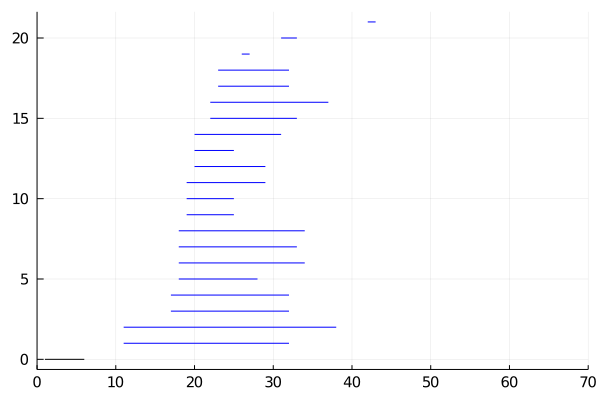

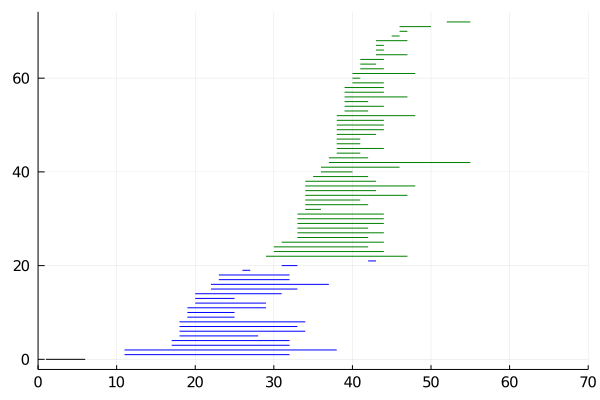

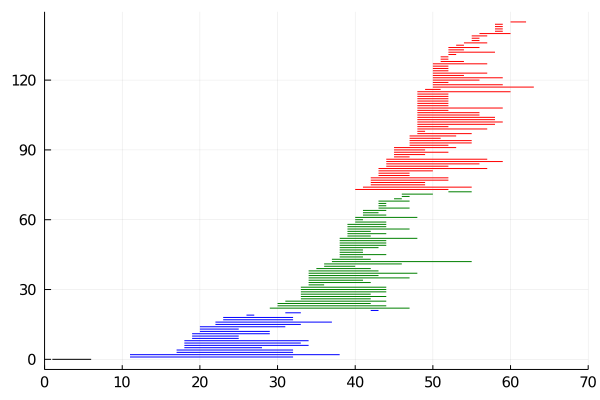

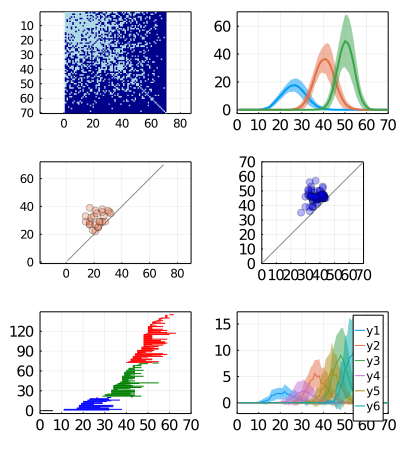

LoadError: UndefVarError: graph_name not defined

In [14]:
gr()
fontSize = 10

p1 = heatmap(G, yflip = true, aspect_ratio = :equal, colorbar = false, color = :blues)
p2 = plot(1:(n + 1), bettiCurve_mean, label = ["B_1" "B_2" "B_3"], lw = 2,
    ribbon = ribbon_std, size = (600,300), framestyle = :box, legend = false,
    xlim = (0, n), xtickfont = font(fontSize), ytickfont = font(fontSize))

p3 = plot(1:n, 1:n, c = RGB(0.55,0.55,0.55), framestyle = :box, aspect_ratio = :equal)
scatter!(barcode1[:,1], barcode1[:,2], markeralpha = 0.3,legend = false)

p4 = plot(1:n, 1:n, c = RGB(0.55,0.55,0.55), framestyle = :box, aspect_ratio = :equal,
    ylim = (0, n), xlim = (0, n))
scatter!(barcode2[:,1], barcode2[:,2], markeralpha = 0.3, c = :blue, aspect_ratio = :equal, legend = false,
    ytickfont = font(fontSize), xtickfont = font(fontSize))

# p5 = plot(1:n, edgeDensityMean, ribbon = edgeDensityStd, legend = false,
#     xlim = (0, n), ytickfont = font(fontSize), xtickfont = font(fontSize))

graphN = 1
p6 = plotBarcode(barcode_array, n, iters, n_dims, fontSize)

p7 = plot(1:n, birthCurveMean, ribbon = birthCurveStd, xlim = (0, n), ytickfont = font(fontSize), 
    xtickfont = font(fontSize))
plot!(1:n, deathCurveMean, ribbon = deathCurveStd)


# p8 = heatmap(degree_array_mean, yflip = true, aspect_ratio = :equal, colorbar = true, color = :magma,
#     ytickfont = font(7), xtickfont = font(fontSize))


pall = plot(p1, p2, p3, p4, p6, p7, layout = (3, 2), size = (400, 450), framestyle = :box)
# pall = plot(p1, p2, p3, p4, p6, p7, layout = (3, 2), size = (400, 450), framestyle = :box)
display(pall)

savefig("$(graph_name).pdf")

Clear variables
s_0_array = nothing
nReps = nothing
nGraphs = nothing
nNodes = nothing

GC.gc()